In [1]:
import os
import torch
import torchvision
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pycocotools.coco import COCO
import numpy as np


In [2]:
# Clone the torchvision repository to get the helper files
def download_helper_files():
    import subprocess
    import shutil

    repo_url = 'https://github.com/pytorch/vision.git'
    clone_dir = 'vision_temp'
    utils_dir = 'vision_utils'

    helper_files = [
        'utils.py',
        'engine.py',
        'coco_utils.py',
        'coco_eval.py',
        'transforms.py',  
        'group_by_aspect_ratio.py',
        'presets.py'
    ]
    
    # Check if utils_dir/utils.py exists
    if not os.path.exists(os.path.join(utils_dir, 'utils.py')):
        # Check if clone_dir exists
        if os.path.exists(clone_dir):
            print(f"'{clone_dir}' exists. Using existing repository.")
        else:
            print("Cloning torchvision repository to download helper files...")
            subprocess.run(['git', 'clone', repo_url, clone_dir])

        # Path to the helper files in the cloned repo
        src_dir = os.path.join(clone_dir, 'references', 'detection')

        # Create the utils directory if it doesn't exist
        if not os.path.exists(utils_dir):
            os.makedirs(utils_dir)

        # Copy the helper files to the utils directory
        for file_name in helper_files:
            src_file = os.path.join(src_dir, file_name)
            dst_file = os.path.join(utils_dir, file_name)
            if os.path.exists(src_file):
                shutil.copy(src_file, dst_file)
                print(f"Copied {file_name} to the utils directory.")
            else:
                print(f"{file_name} not found in the repository.")

        # Optionally, remove the cloned repository
        # If you want to remove 'vision_temp' after copying, uncomment the following lines:
        # shutil.rmtree(clone_dir)
        # print("Removed temporary cloned repository.")
    else:
        print("Helper files already exist in the utils directory.")

# Download the helper files
download_helper_files()


Helper files already exist in the utils directory.


In [3]:
# Verify that MetricLogger exists in utils.py
with open('vision_utils/utils.py', 'r') as file:
    content = file.read()
    if 'class MetricLogger' in content:
        print("MetricLogger class is present in utils.py")
    else:
        print("MetricLogger class is NOT present in utils.py")


MetricLogger class is present in utils.py


In [4]:
import sys
sys.path.append('vision_utils')

from vision_utils import utils
from vision_utils import engine
from vision_utils.engine import train_one_epoch
from vision_utils.utils import collate_fn

In [5]:
class COCOMaskDataset(Dataset):
    def __init__(self, root, annFile, transforms=None, limit=128):
        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(sorted(self.coco.imgs.keys()))

        # Filter out images without annotations
        self.ids = [img_id for img_id in self.ids if len(self.coco.getAnnIds(imgIds=img_id)) > 0]
        
        # Apply limit to the dataset if provided
        if limit is not None:
            self.ids = self.ids[:limit]

        self.transforms = transforms

    def __getitem__(self, index):
        # Get image ID
        img_id = self.ids[index]
        # Load image
        img_info = self.coco.loadImgs(img_id)[0]
        path = img_info['file_name']
        img = Image.open(os.path.join(self.root, path)).convert("RGB")

        # Load annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # Extract boxes, labels, masks
        boxes = []
        labels = []
        masks = []
        for ann in anns:
            x_min, y_min, width, height = ann['bbox']
            # Check for valid box (height and width should be positive)
            if width > 0 and height > 0:
                boxes.append([x_min, y_min, x_min + width, y_min + height])
                labels.append(ann['category_id'])
                masks.append(self.coco.annToMask(ann))

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        # Additional fields
        image_id = torch.tensor([img_id])
        area = torch.as_tensor([ann['area'] for ann in anns if ann['area'] > 0], dtype=torch.float32)
        iscrowd = torch.as_tensor([ann['iscrowd'] for ann in anns], dtype=torch.int64)

        # Compile target
        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': image_id,
            'area': area,
            'iscrowd': iscrowd
        }

        # Apply the transforms to the image if any
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.ids)


In [6]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        # Add data augmentation here if needed
        pass
    return T.Compose(transforms)


In [7]:
import torchvision
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_V2_Weights

def get_instance_segmentation_model(num_classes):
    # Load an instance segmentation model pre-trained on COCO with updated weights
    weights = MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1
    model = torchvision.models.detection.maskrcnn_resnet50_fpn_v2(weights=weights)

    # Get number of input features for the box classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained box head with a new one for fine-tuning
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features, num_classes)

    # Get number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # Replace the mask predictor with a new one for fine-tuning
    model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes)

    return model


In [8]:
# Specify the path
path = r'C:\Users\alway\OneDrive\Documents\GitHub\Applied-AI\hw2\datasets\coco_dataset\annotations'

# List all files in the specified directory
files = os.listdir(path)

# Print the list of files
print("Files in the annotations directory:")
for file in files:
    print(file)


Files in the annotations directory:
captions_train2017.json
captions_val2017.json
instances_train2017.json
instances_val2017.json
person_keypoints_train2017.json
person_keypoints_val2017.json


In [9]:
# Use GPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
# Base directory
base_dir = r'C:/Users/alway/OneDrive/Documents/GitHub/Applied-AI/hw2/datasets/coco_dataset'

# Paths to images and annotations
train_dir = os.path.join(base_dir, 'train2017')
train_ann_file = os.path.join(base_dir, 'annotations', 'instances_train2017.json')
val_dir = os.path.join(base_dir, 'val2017')
val_ann_file = os.path.join(base_dir, 'annotations', 'instances_val2017.json')

# Create datasets
dataset = COCOMaskDataset(train_dir, train_ann_file, transforms=get_transform(train=True))
dataset_test = COCOMaskDataset(val_dir, val_ann_file, transforms=get_transform(train=False))

# Define data loaders
data_loader = DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)


cuda
loading annotations into memory...
Done (t=24.30s)
creating index...
index created!
loading annotations into memory...
Done (t=1.27s)
creating index...
index created!


In [10]:
# Number of classes (including background)
num_classes = 91  # COCO has 80 classes + 1 background + some extra

# Get the model using the helper function
model = get_instance_segmentation_model(num_classes)
# Move model to the right device
model.to(device)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [11]:
# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=3, gamma=0.1)


In [12]:
#debuging functions missing etc
import utils
print("utils module imported from:", utils.__file__)

import engine
print("engine module imported from:", engine.__file__)

print("PyTorch version:", torch.__version__)
print("TorchVision version:", torchvision.__version__)

import sys
for path in sys.path:
    possible_utils = os.path.join(path, 'utils.py')
    if os.path.exists(possible_utils):
        print(f"Found utils.py at: {possible_utils}")



utils module imported from: c:\Users\alway\OneDrive\Documents\GitHub\Applied-AI\hw2\rcnn\vision_utils\utils.py
engine module imported from: c:\Users\alway\OneDrive\Documents\GitHub\Applied-AI\hw2\rcnn\vision_utils\engine.py
PyTorch version: 2.4.1+cu118
TorchVision version: 0.19.1+cu118
Found utils.py at: vision_utils\utils.py


In [13]:
print("CUDA Available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device())
print("Device Name:", torch.cuda.get_device_name(torch.cuda.current_device()))


CUDA Available: True
Number of GPUs: 1
Current Device: 0
Device Name: NVIDIA GeForce RTX 3070 Laptop GPU


In [14]:
def verify_dataset(dataset, num_samples_to_check=50):
    print(f"Verifying the first {num_samples_to_check} samples of the dataset...")
    
    for i in range(min(num_samples_to_check, len(dataset))):
        try:
            img, target = dataset[i]
            
            # Check if boxes are empty
            if target['boxes'].numel() == 0:
                print(f"Warning: Sample {i} has no bounding boxes.")
            # else:
                # Optionally print information about the data
                # print(f"Sample {i}: Image size: {img.size()}, Boxes: {target['boxes'].size()}")

            # Check if masks, labels, and other fields are not empty
            if target['masks'].numel() == 0:
                print(f"Warning: Sample {i} has no masks.")
            if target['labels'].numel() == 0:
                print(f"Warning: Sample {i} has no labels.")

        except Exception as e:
            print(f"Error with sample {i}: {e}")

    print("Dataset verification complete.")

verify_dataset(dataset)

train_ids = set(dataset.ids)
val_ids = set(dataset_test.ids)
common_ids = train_ids.intersection(val_ids)



Verifying the first 50 samples of the dataset...


C:\Users\alway\AppData\Local\Temp\ipykernel_8484\1072060860.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)


Dataset verification complete.


In [15]:
num_epochs = 1

for epoch in range(num_epochs):
    # Train for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # Update the learning rate
    lr_scheduler.step()

c:\Users\alway\OneDrive\Documents\GitHub\Applied-AI\hw2\rcnn\vision_utils\engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/64]  eta: 0:02:09  lr: 0.000084  loss: 5.8955 (5.8955)  loss_classifier: 4.6728 (4.6728)  loss_box_reg: 0.4492 (0.4492)  loss_mask: 0.6859 (0.6859)  loss_objectness: 0.0348 (0.0348)  loss_rpn_box_reg: 0.0528 (0.0528)  time: 2.0193  data: 0.3022  max mem: 4125
Epoch: [0]  [63/64]  eta: 0:00:03  lr: 0.005000  loss: 1.8761 (2.7916)  loss_classifier: 0.6825 (1.4727)  loss_box_reg: 0.4215 (0.5087)  loss_mask: 0.6328 (0.6830)  loss_objectness: 0.0468 (0.0741)  loss_rpn_box_reg: 0.0205 (0.0532)  time: 4.1588  data: 0.7856  max mem: 6199
Epoch: [0] Total time: 0:03:27 (3.2446 s / it)


In [16]:
# Save the trained model
torch.save(model.state_dict(), 'mask_rcnn_coco.pth')
print("Model saved as mask_rcnn_coco.pth")


Model saved as mask_rcnn_coco.pth


In [17]:
# Get the first batch from the test data loader
dataiter = iter(data_loader_test)
images, targets = next(dataiter)

# Get the first image and its target
img = images[0]
target = targets[0]
# Move the image to the device
img = img.to(device)
# Set the model to evaluation mode
model.eval()

# Run inference
with torch.no_grad():
    prediction = model([img])

# Move outputs to CPU and convert to NumPy arrays
pred_boxes = prediction[0]['boxes'].cpu().numpy()
pred_labels = prediction[0]['labels'].cpu().numpy()
pred_scores = prediction[0]['scores'].cpu().numpy()
pred_masks = prediction[0]['masks'].cpu().numpy()

print("Prediction results:")
print(f"Boxes: {pred_boxes}")
print(f"Labels: {pred_labels}")
print(f"Scores: {pred_scores}")
print(f"Masks: {pred_masks}")



Prediction results:
Boxes: [[411.90976   145.47739   468.5224    298.76575  ]
 [384.69016   172.63521   400.4329    211.17561  ]
 [435.06406   153.97438   465.13412   294.55063  ]
 [300.33005   200.49251   354.9471    317.30527  ]
 [227.09396   177.69804   267.06207   212.77592  ]
 [555.1315    263.06284   592.04376   403.07904  ]
 [357.76755   204.29391   428.48257   334.00104  ]
 [368.1087    209.28873   414.5724    300.6291   ]
 [ 46.71017   207.50903    62.386616  244.34227  ]
 [458.6495    159.08495   466.88815   168.06232  ]
 [483.8667    167.34274   512.693     287.32907  ]
 [546.8387    197.88712   636.69104   395.2937   ]
 [407.8984    213.98561   443.2089    308.51062  ]
 [360.308     213.34831   374.17847   231.61368  ]
 [331.84027   173.22667   379.51672   232.77112  ]
 [166.29689   230.56154   185.99149   269.00708  ]
 [315.03656   190.33838   323.8873    214.9712   ]
 [444.7773    117.37346   464.93964   145.58429  ]
 [448.72083   120.006714  460.8693    143.18005  ]
 [41

loading annotations into memory...
Done (t=0.74s)
creating index...
index created!


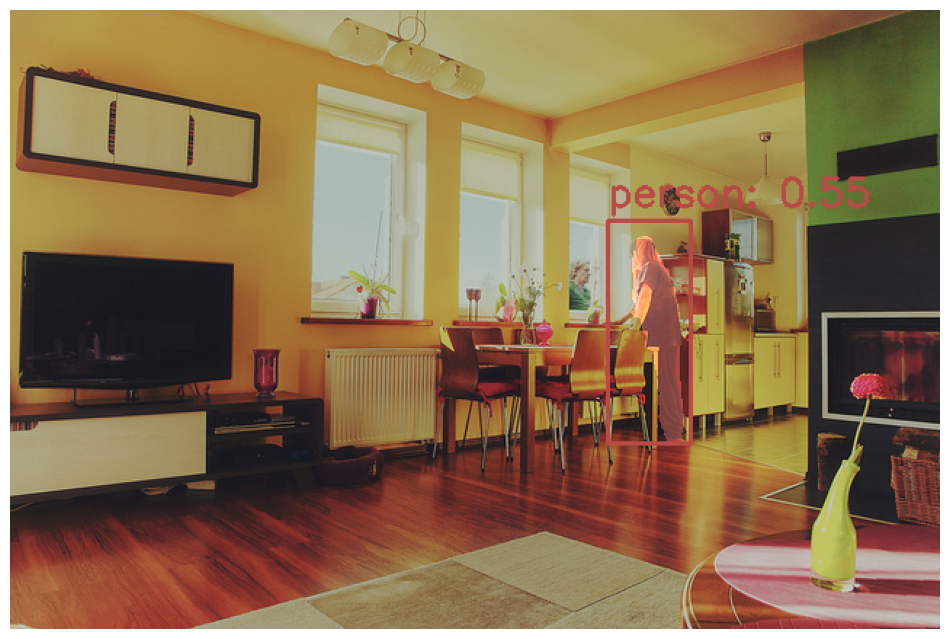

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pycocotools.coco import COCO

# Convert the tensor image to a NumPy array and transpose dimensions
img_np = img.cpu().numpy().transpose((1, 2, 0))

# Denormalize the image if necessary (assuming images are in [0,1] range)
img_np = (img_np * 255).astype(np.uint8)

# Load COCO categories for label mapping
coco = COCO(val_ann_file)  # Use your validation annotations file
cats = coco.loadCats(coco.getCatIds())
labels_map = {cat['id']: cat['name'] for cat in cats}

# Set a score threshold
score_threshold = 0.5

# Copy the image to draw on
img_result = img_np.copy()

# Overlay masks and bounding boxes
for idx, score in enumerate(pred_scores):
    if score > score_threshold:
        # Get the mask
        mask = pred_masks[idx, 0]
        mask = mask > 0.5  # Binarize the mask

        # Generate a random color
        color = np.random.randint(0, 255, size=3, dtype=np.uint8)

        # Create a colored mask
        colored_mask = np.zeros_like(img_np, dtype=np.uint8)
        for c in range(3):
            colored_mask[:, :, c] = mask * color[c]

        # Overlay the mask on the image
        img_result = cv2.addWeighted(img_result, 1.0, colored_mask, 0.5, 0)

        # Get the bounding box
        box = pred_boxes[idx]
        # Draw the bounding box
        cv2.rectangle(img_result, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color.tolist(), 2)

        # Get the label name
        label_id = pred_labels[idx]
        label_name = labels_map.get(label_id, f'ID {label_id}')
        # Put the label text above the bounding box
        cv2.putText(img_result, f"{label_name}: {score:.2f}", (int(box[0]), int(box[1]) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, color.tolist(), 2)

# Display the final image
plt.figure(figsize=(12, 12))
plt.imshow(img_result)
plt.axis('off')
plt.show()
